---
title: "HDA Climate DT Parameter Plotter - Tutorial"
subtitle: "This notebook provides an interactive workflow to select, query, download, and visualize Climate Digital Twin parameters from the DestinE Data Lake using the DEDL HDA API."
author: "Michael Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, ECMWF, earthkit, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE_Digital_Twins/ClimateDT-ParameterPlotter.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b><ul>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li></ul>
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>

This notebook demonstrates how to access DT data for different types of simulations via **HDA (Harmonized Data Access)** API.

A correct combination of parameters is necessary to access DT data for different types of simulations.
The aim of this notebook is to help you create the correct request to access the desired Climate DT data, through HDA, and visualize it.


Below the main steps covered by this tutorial.

1. [Setup](#ClimateDT-ParameterPlotter.ipynb-Setup): Import the required libraries and define some function. 
2. [Simulation Selection](#ClimateDT-ParameterPlotter.ipynb-Scenario-Simulation-Selection):  Print and select the desired scenario simulation for accessing Climate DT data.  
3. [Parameter Selection](#ClimateDT-ParameterPlotter.ipynb-Parameter-Selection): How to select the desired Climate DT variable among the ones available through the selected scenario.
4. [Levels Selection](#ClimateDT-ParameterPlotter.ipynb-Levels-Selection): How to Handle different Levels to be selected (if any).
5. [Order and Download](#ClimateDT-ParameterPlotter.ipynb-Order-and-Download): How to order and download Climate DT data.
6. [Plot](#ClimateDT-ParameterPlotter.ipynb-EarthKit): How to visualize hourly data on single levels data through Earthkit.

(ClimateDT-ParameterPlotter.ipynb-Setup)=
# Setup

Import the required packages and define some constants.

In [1]:
import destinelab as deauth
from destinelab import climate_dt_dictionary
import ipywidgets as widgets
import json
from datetime import date, datetime, timedelta
import importlib
import importlib.metadata as metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
import re
from getpass import getpass
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON

import sys
import subprocess
from packaging import version
import pandas as pd

from IPython.display import display, HTML
import ipywidgets as w

Define some useful funtions.

In [7]:
# parse STAC temporal interval into date objects
def parse_time_extent(col):
    itv = (((col.get("extent") or {}).get("temporal") or {}).get("interval") or [[]])
    start_iso, end_iso = (itv[0] + [None, None])[:2]
    to_date = lambda s: (datetime.fromisoformat(s.replace("Z","")).date() if s else None)
    sd, ed = to_date(start_iso), to_date(end_iso)
    s_txt = sd.isoformat() if sd else "open"
    e_txt = ed.isoformat() if ed else "open"
    return sd, ed, f"{s_txt} → {e_txt}"

def show_collection_info(change):
    out.clear_output()
    col = col_map[change["new"]]

    desc = col.get("dedl:short_description", "").strip()
    kws = [k for k in col.get("keywords", []) if ":" in k]

    # NEW: parse and display time extent; update state for next cell
    sd, ed, extent_txt = parse_time_extent(col)
    selected["id"] = col["id"]
    selected["start_date"] = sd
    selected["end_date"] = ed

    with out:
        print("Scenarion Description:\n--------------")
        print(desc if desc else "(no description)")
        print("\nScenario simulation parameters\n--------------")
        print("\n".join(kws) if kws else "(none found)")
        print("\nTime extent:\n--------------")
        print(extent_txt)

def show_variable_info(_):
    q = txt.value.lower()
    with out:
        out.clear_output()
        matches = [k for k in keys if q in k.lower()]
        for k in matches:
            print(k)
            if len(matches) == 1:
                var = collection_json["collections"][0]["cube:variables"][k]
                print(var.get("description","").strip(), "\n")

                attrs = var.get("attrs", {})
                # --- Save what you need for later use ---
                var_sel["name"] = k
                var_sel["parameter_ID"] = attrs.get("parameter_ID")
                var_sel["levtype"]      = attrs.get("levtype")
                var_sel["time"]         = attrs.get("time")
                var_sel["levelist"]     = attrs.get("levelist")

                # show the attrs (optional)
                print(json.dumps(attrs, indent=2))

                # quick confirmation (optional)
                print("\nSaved selection:")
                print({k: var_sel[k] for k in ["name","parameter_ID","levtype","time"]})

#shows dates selection
def refresh(_=None):
    d = dp.value or (selected["start_date"] or date.today())
    h, m = map(int, (hh.value or "00:00").split(":"))
    dt = datetime(d.year, d.month, d.day, h, m)
    out2.value = f"<b>Collection:</b> {selected['id']}<br><b>DateTime (UTC):</b> {dt.isoformat()}Z"

#shows hours and levels selection
def refresh_hl(_=None):
    # Persist hour (if shown)
    if hour_dd is not None:
        var_sel["hour"] = hour_dd.value  # e.g., "14:00"
    else:
        var_sel.pop("hour", None)

    # Persist selected levels as a list (if shown)
    if levels_ms is not None:
        var_sel["levels"] = list(levels_ms.value)  # e.g., ["11","100"]
    else:
        var_sel.pop("levels", None)

    with out:
        out.clear_output()
        print(f"Variable: {var_sel.get('name')}")
        print(f"Time: {var_sel.get('time')}  |  Levtype: {var_sel.get('levtype')}")
        if "hour" in var_sel:
            print(f"Selected hour: {var_sel['hour']}")
        if "levels" in var_sel:
            print(f"Selected levels: {var_sel['levels'] if var_sel['levels'] else '(none)'}")
        if levels_ms is None:
            print("No levels selector (no 'levelist' provided).")


define some useful constants

In [3]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
print("STAC endpoint: ", HDA_STAC_ENDPOINT)

STAC endpoint:  https://hda.data.destination-earth.eu/stac/v2


In [4]:
HDA_DISCOVERY_ENDPOINT = HDA_STAC_ENDPOINT+'/collections'
print("HDA discovery endpoint: ", HDA_DISCOVERY_ENDPOINT)

HDA discovery endpoint:  https://hda.data.destination-earth.eu/stac/v2/collections


(ClimateDT-ParameterPlotter.ipynb-Scenario-Simulation-Selection)=
# Scenario Simulation Selection
The Climate DT exploits and further evolves a new generation of global models. 
Multi-decadal simulations are produced to cover the recent past (from 1990) and possible future evolutions of the climate.

The simulations of the past are used to evaluate the model quality before using the future projection to quantify how characteristics of the climate and weather change over the next decades. So-called storyline simulations, are carried out to reconstruct the unfolding of recent extreme events, such as heatwaves, floods, and droughts across various climate conditions.    

Accessing the available Climate DT simulations through HDA requires selecting the corresponding Climate DT collections.

The table below lists the **HDA collection ID** and titles corresponding to the **Climate DT simulations** produced during the first phase of DestinE**.

In [5]:
URL = HDA_DISCOVERY_ENDPOINT
params = {
    "limit": 12,
    "q": '"Climate Change Adaptation Digital Twin","model","activity", "experiment"',  # keep the quotes to search the phrase
}

resp = requests.get(URL, params=params, timeout=60)
resp.raise_for_status()
discovery_json = resp.json()

# Build table with id and title
rows = []
for c in discovery_json.get("collections", []):
    interval = c.get("extent").get("temporal").get("interval")
    start, end = interval[0]
    start_date = start.split("T")[0]
    end_date   = end.split("T")[0]

    rows.append({
        "HDA - Climate DT collection title": c.get("title"),
        "HDA - Climate DT collection ID": c.get("id") ,
        "Time Extension": ""+start_date+" "+ end_date+""
    })

df = pd.DataFrame(rows).reset_index(drop=True)
HTML(df.to_html(index=False))

HDA - Climate DT collection title,HDA - Climate DT collection ID,Time Extension
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Historical Simulation - ICON,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.CMIP6_HIST_ICON.R1,1993-01-01 2019-12-31
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Historical Simulation - IFS-NEMO,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.CMIP6_HIST_IFS-NEMO.R1,1990-01-01 2002-02-28
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Control Simulation - IFS-FESOM,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.HIGHRESMIP_CONT_IFS-FESOM.R1,1990-01-01 2004-12-31
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Control Simulation - IFS-NEMO,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.HIGHRESMIP_CONT_IFS-NEMO.R1,1990-01-01 2007-04-30
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Future Projection - ICON,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_ICON.R1,2020-09-01 2039-12-31
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Future Projection - IFS-FESOM,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-FESOM.R1,2020-01-01 2039-12-31
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Future Projection - IFS-NEMO,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1,2020-01-01 2039-12-31
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Storyline Simulation Present Climate - IFS-FESOM,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.STORY-NUDGING_CONT_IFS-FESOM.R1,2017-01-01 2024-11-15
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Storyline Simulation Past Climate - IFS-FESOM,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.STORY-NUDGING_HIST_IFS-FESOM.R1,2017-01-01 2024-11-15
Climate Change Adaptation Digital Twin (Climate Adaptation DT) - Storyline Simulation Future Climate - IFS-FESOM,EO.ECMWF.DAT.D1.DT_CLIMATE.G1.STORY-NUDGING_TPLUS2.0K_IFS-FESOM.R1,2017-01-01 2024-11-15


The cell below allows to select the collection ID corresponding to your scenario simulation of interest and start building your data request.
The cell shows the simulations parameters of the scenario selected.

In [6]:

collections = discovery_json.get("collections", [])

# mapping: id → collection object
col_map = {c["id"]: c for c in collections}

# ---- state container you can reuse in following cells ----
selected = {"id": None, "start_date": None, "end_date": None}

# Combo box with collection IDs
dd = w.Dropdown(options=sorted(col_map.keys()), description="Collection:")
out = w.Output()
dd.observe(show_collection_info, names="value")

display(dd, out)
show_collection_info({"new": dd.value})   # show initial selection

Dropdown(description='Collection:', options=('EO.ECMWF.DAT.D1.DT_CLIMATE.G1.CMIP6_HIST_ICON.R1', 'EO.ECMWF.DAT…

Output()

The cell below allows to select a date in the range corresponding to your scenario simulation of interest.

Choosing a data and a scenario helps to start building your data request. 

In [8]:

# Date picker constrained to the collection’s time extent
dp = w.DatePicker(
    description="Date:",
    value=selected["start_date"] or date.today(),
    disabled=False,
    # ipywidgets DatePicker supports min/max in recent versions
)
# set min/max if available
if selected["start_date"]:
    dp.min = selected["start_date"]
if selected["end_date"]:
    dp.max = selected["end_date"]

# Hour selector (00–23)
hours = [f"{h:02d}:00" for h in range(24)]
hh = w.Dropdown(options=hours, description="Hour:")

# Display the final ISO datetime + collection id
out2 = w.HTML()

dp.observe(refresh, names="value")
hh.observe(refresh, names="value")

display(dp, hh, out2)
refresh()

DatePicker(value=datetime.date(2020, 1, 1), description='Date:', max=datetime.date(2039, 12, 31), min=datetime…

Dropdown(description='Hour:', options=('00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00',…

HTML(value='')

In [9]:
COLLECTION_ID=selected['id']
# Date as a datetime.date
chosen_date = dp.value

# Time as "HH:MM"
chosen_time_str = hh.value

print (chosen_date,chosen_time_str)

2036-01-16 00:00


(ClimateDT-ParameterPlotter.ipynb-Parameter-Selection)=
# Parameter Selection

Climate DT variable selection (we limit the plotting to one variable).
The variable selection is conditioned by the chosen simulation scenario.



In [26]:
collection_json = requests.get(HDA_DISCOVERY_ENDPOINT,
                               params={"q": f"{selected['id']}"}).json()

print("Type in the text box to narrow the list.")
print("When only one item remains, its details will appear and the parameter will be selected for your data request")

keys = sorted(collection_json["collections"][0]["cube:variables"])
txt = w.Text(description="")
out = w.Output()

# container to reuse later (in following cells)
var_sel = {"parameter_ID": None, "levtype": None, "time": None, "name": None}

txt.observe(show_variable_info, names="value")
display(txt, out)
show_variable_info(None)

Type in the text box to narrow the list.
When only one item remains, its details will appear and the parameter will be selected for your data request


Text(value='')

Output()

Let's see the  details of the selected parameter (Polytope convention).
It is possible to check the its characteristics, time resolution, levels... 

## Hour and levels selection (if available)

In [33]:

# ensure a variable was selected earlier ---
if not var_sel or not var_sel.get("name"):
    raise ValueError("Please select a variable by narrowing down the list in the cell above!")

widgets = []
hour_dd = None
levels_ms = None

# 1) Hour selector only if time is 'Hourly'
if var_sel.get("time") == "Hourly":
    hour_dd = w.Dropdown(
        options=[f"{h:02d}:00" for h in range(24)],
        value="00:00",
        description="Hour:"
    )
    widgets.append(hour_dd)

# 2) Levels selector only if levelist exists; split on commas, slashes, or whitespace
lvl_raw = var_sel.get("levelist")
levels = []
if isinstance(lvl_raw, str) and lvl_raw.strip():
    # split by comma, slash or whitespace, keep only numeric tokens
    tokens = re.split(r"[,\s/]+", lvl_raw.strip())
    levels = [t for t in tokens if t.isdigit()]
elif isinstance(lvl_raw, (list, tuple)):
    levels = [str(x) for x in lvl_raw if str(x).strip().isdigit()]

if levels:
    levels_ms = w.SelectMultiple(
        options=levels,
        value=(),  # nothing preselected
        rows=min(10, max(5, len(levels))),
        description="Levels:"
    )
    widgets.append(levels_ms)

out = w.Output()

# Wire events
if hour_dd is not None:
    hour_dd.observe(refresh_hl, names="value")
if levels_ms is not None:
    levels_ms.observe(refresh_hl, names="value")

display(*(widgets + [out]))
refresh_hl()

Dropdown(description='Hour:', options=('00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00',…

SelectMultiple(description='Levels:', options=('1000', '925', '850', '700', '600', '500', '400', '300', '250',…

Output()

<div class="alert alert-block alert-danger">
<b> Note:</b>
    
Please note that the multilevel requests are temporarly not allowed, but they will be soon. Please select only one leel in the meantime
</div>

We have now selected all the information needed to perform a data request

# Order and Download

## Obtain Authentication Token

To perform our request we need to be authenticated. 
Below to request of an authentication token.

In [39]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [40]:
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA data request with the made selections

Use the chosen parameters to construct an HDA Climate DT data request, then output the filters that were created.

In [41]:
filter_params = {
  "ecmwf:resolution": "standard",      # can be tandard or high 
  "ecmwf:type": "fc",              # fixed forecasted fields
  "ecmwf:levtype": var_sel["levtype"],  
  "ecmwf:param": str(var_sel["parameter_ID"])
}

# Check if levelist is empty and remove it
if (var_sel.get("levelist")):
    filter_params["ecmwf:levelist"]="/".join(var_sel['levels'])

if (var_sel.get("hour")):
    filter_params["ecmwf:time"]=var_sel['hour'].replace(":", "")

hdaFilters = {
    key: {"eq": value}
    for key, value in filter_params.items()
}
print("HDA search request body for our data of interest:")
JSON(hdaFilters)

HDA search request body for our data of interest:


<IPython.core.display.JSON object>

### Filtering
Asynchronous dataset searches—such as those for Digital Twins—return exactly one item. 

This item provides both the correct API endpoint and the complete request body needed to execute the data order.

In [42]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
 "collections": [COLLECTION_ID],
    "datetime": f'{chosen_date.isoformat()}T00:00Z',
    "query":  hdaFilters
})

if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

The single item returned (above) contains:
- The product id: "DT_CLIMATE_ADAPTATION_ORDERABLE_...", that is a placeholder, its name contains the term "ORDERABLE".
- The storage:tier that indicates that the product is "offline"
- The order:status that indicates that the product is "orderable"
- Request params used for the order extracted from the search result

In [43]:
link = next((l for l in product.get('links', []) if l.get("rel") == "retrieve"), None)

if link:
    href = link.get("href")
    body = link.get("body")   # optional: depends on extension
    print("order endpoint:", href)
    print("order body, same as the polytope format:")
    print(json.dumps(body, indent=4))
else:
    print(f"No link with rel='{target_rel}' found")


order endpoint: https://hda.data.destination-earth.eu/stac/v2/collections/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/order
order body, same as the polytope format:
{
    "activity": "ScenarioMIP",
    "class": "d1",
    "dataset": "climate-dt",
    "date": "20360116/to/20360116",
    "experiment": "SSP3-7.0",
    "expver": "0001",
    "generation": "1",
    "levelist": "1000",
    "levtype": "pl",
    "model": "IFS-NEMO",
    "param": "157",
    "realization": "1",
    "resolution": "standard",
    "stream": "clte",
    "time": "1200",
    "type": "fc"
}


(ClimateDT-ParameterPlotter.ipynb-Order-and-Download)=
## Order data

We have now all the information to order the data.

From the search results we know that the product is orderable and offline, we then need to order the product we searched for.

In [44]:
response = requests.post(href, json=body, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")    

Product ordered: 3d5be284-0916-493c-85de-4d55d367953f
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered


### Poll the API until product is ready

We request the product itself to get an update of its status.

In [45]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    


Polling 1/300
Product is ready to be downloaded.
Asset URL: https://hda-download.leonardo.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/3d5be284-0916-493c-85de-4d55d367953f/downloadLink


# Download

In [46]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 3d5be284-0916-493c-85de-4d55d367953f.grib", attachment; 


529kB [00:00, 2.65MB/s]


(ClimateDT-ParameterPlotter.ipynb-EarthKit)=
## EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html) selecting only the Europe area in the plot.

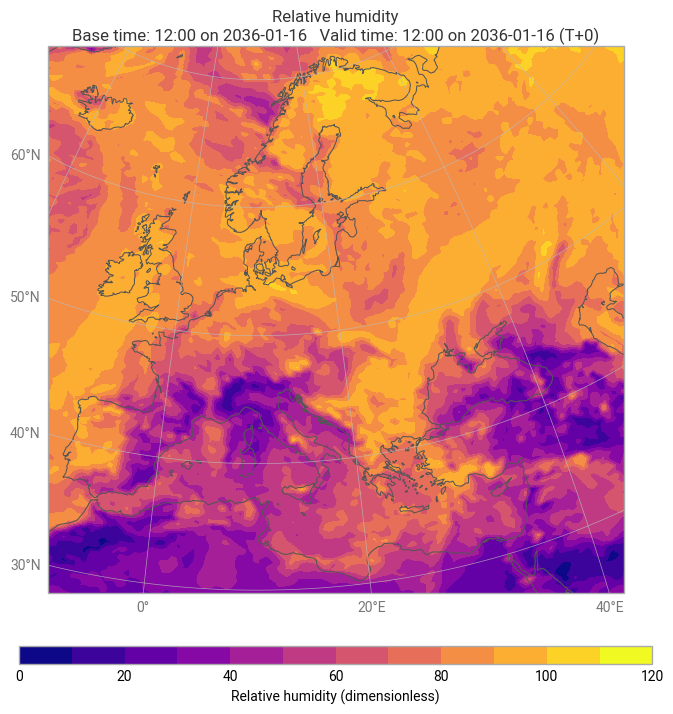

In [47]:
import earthkit.data
import earthkit.plots
import earthkit.regrid

data = earthkit.data.from_source("file", filename)
earthkit.plots.quickplot(data,domain="Europe")